## Frequent patterns and association rules

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [82]:
from utils import load_data
data = load_data('./Data/Dataset3.csv')

In [83]:
data.iloc[0,0] 
data.head(10)

,Temperature,Humidity,Rainfall,Soil,Crop,Fertilizer
0,"24,87","82,84","295,61",Clayey,rice,DAP
1,"28,69","96,65","178,96",laterite,Coconut,Good NPK
2,"20,27","81,64","270,44",silty clay,rice,MOP
3,"25,07","95,02","192,9",sandy,Coconut,Urea
4,"25,04","95,9","174,8",coastal,Coconut,Urea
5,"20,82","84,13","230,22",clay loam,rice,Urea
6,"25,95","93,41","172,05",alluvial,Coconut,Urea
7,"26,49","80,16","242,86",Clayey,rice,DAP
8,"25,01","95,59","165,81",coastal,Coconut,Urea
9,"21,87","80,19","224,56",silty clay,rice,Urea


In [84]:
from utils import describe_column
colonnes_description = describe_column(data)
pd.DataFrame(colonnes_description, columns = ["Name","Non-null value","Type"])

,Name,Non-null value,Type
0,Temperature,295,object
1,Humidity,295,object
2,Rainfall,295,object
3,Soil,295,object
4,Crop,295,object
5,Fertilizer,295,object


<h1>2.1. Discrétisation des données 

<h2>a- Classes d’effectifs égaux (equal frequency)

In [85]:
from utils import equal_width_discretization
column_name = "Rainfall"
df_after = equal_width_discretization(data, column_name, 1)
df_after

,Temperature,Humidity,Rainfall,Soil,Crop,Fertilizer,Discretized
0,"24,87","82,84",295.61,Clayey,rice,DAP,9
1,"28,69","96,65",178.96,laterite,Coconut,Good NPK,3
2,"20,27","81,64",270.44,silty clay,rice,MOP,8
3,"25,07","95,02",192.90,sandy,Coconut,Urea,4
4,"25,04","95,9",174.80,coastal,Coconut,Urea,3
...,...,...,...,...,...,...,...
290,"26,07","96,7",143.53,sandy,Coconut,MOP,1
291,"25,63","83,53",209.90,silty clay,rice,MOP,5
292,"24,52","83,54",230.45,Clayey,rice,MOP,6
293,"25,66","83,47",217.38,Clayey,rice,MOP,5


In [86]:
from utils import equal_frequency_discretization
df_after2 = equal_frequency_discretization(data, column_name, 1)
df_after2

,Temperature,Humidity,Rainfall,Soil,Crop,Fertilizer,Discretized
0,"24,87","82,84",295.61,Clayey,rice,DAP,9
1,"28,69","96,65",178.96,laterite,Coconut,Good NPK,3
2,"20,27","81,64",270.44,silty clay,rice,MOP,9
3,"25,07","95,02",192.90,sandy,Coconut,Urea,4
4,"25,04","95,9",174.80,coastal,Coconut,Urea,3
...,...,...,...,...,...,...,...
290,"26,07","96,7",143.53,sandy,Coconut,MOP,1
291,"25,63","83,53",209.90,silty clay,rice,MOP,6
292,"24,52","83,54",230.45,Clayey,rice,MOP,7
293,"25,66","83,47",217.38,Clayey,rice,MOP,6


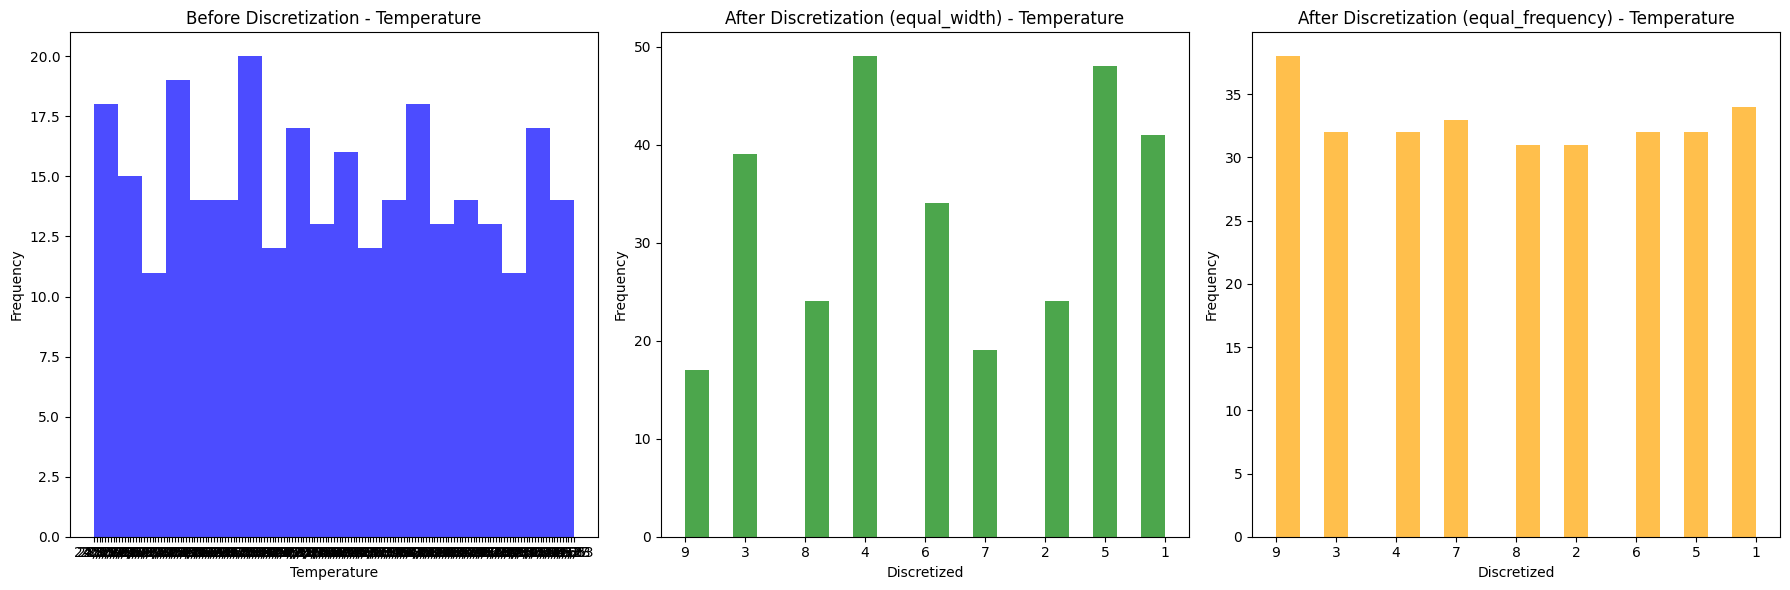

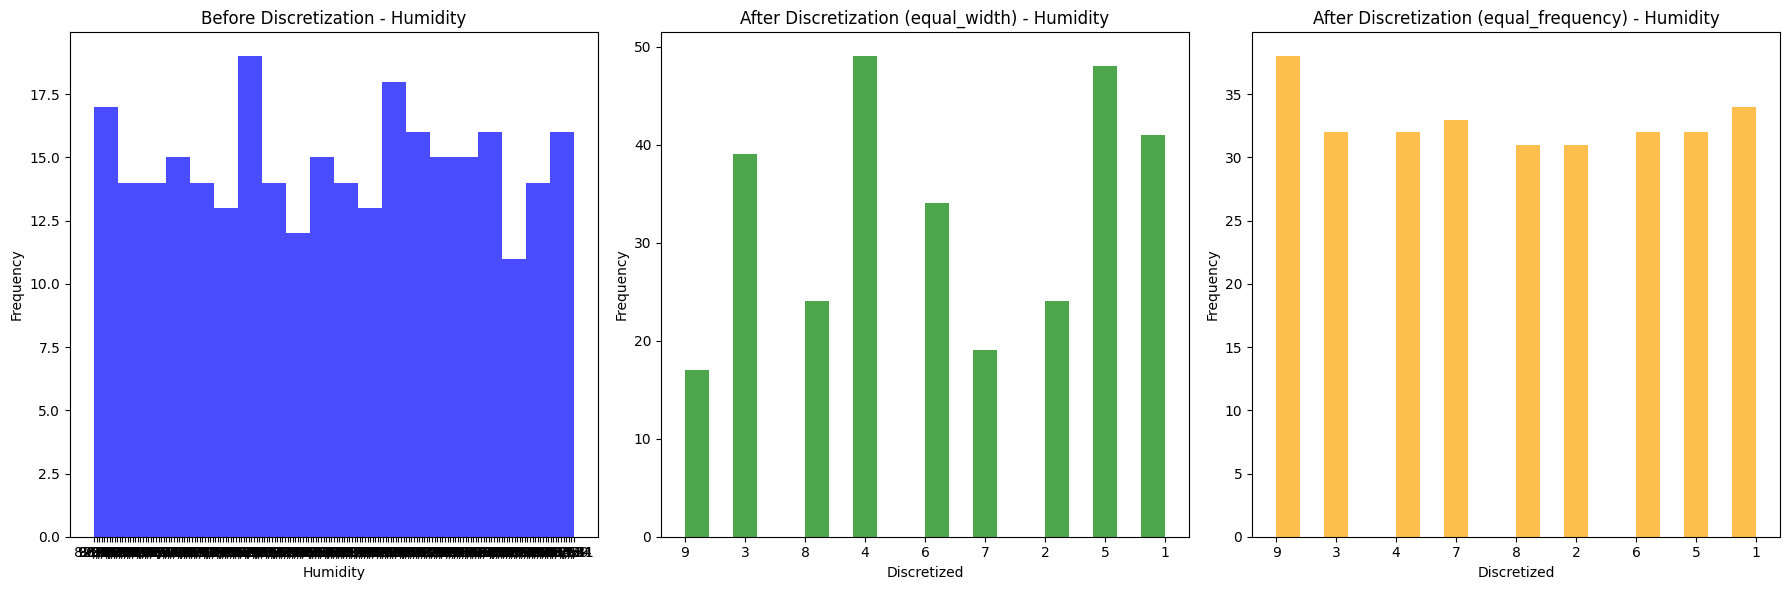

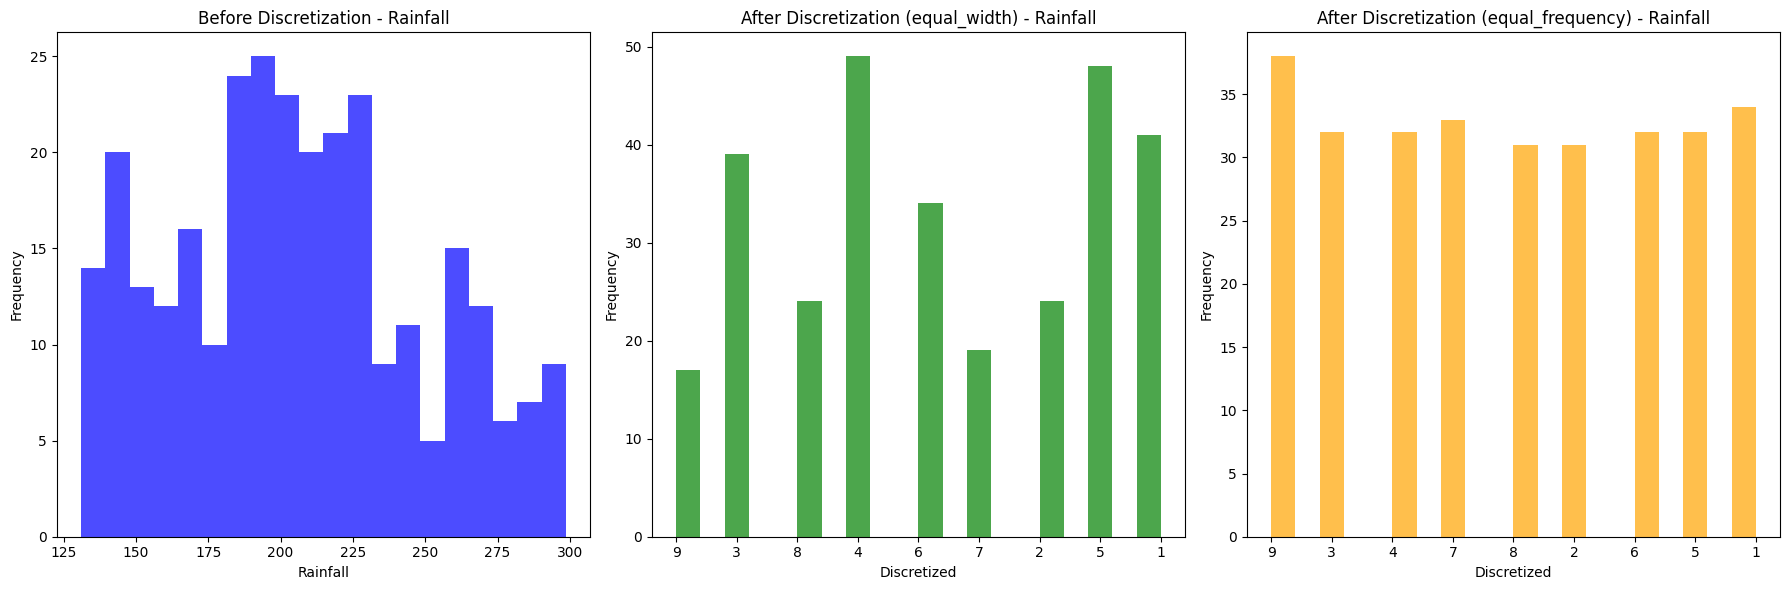

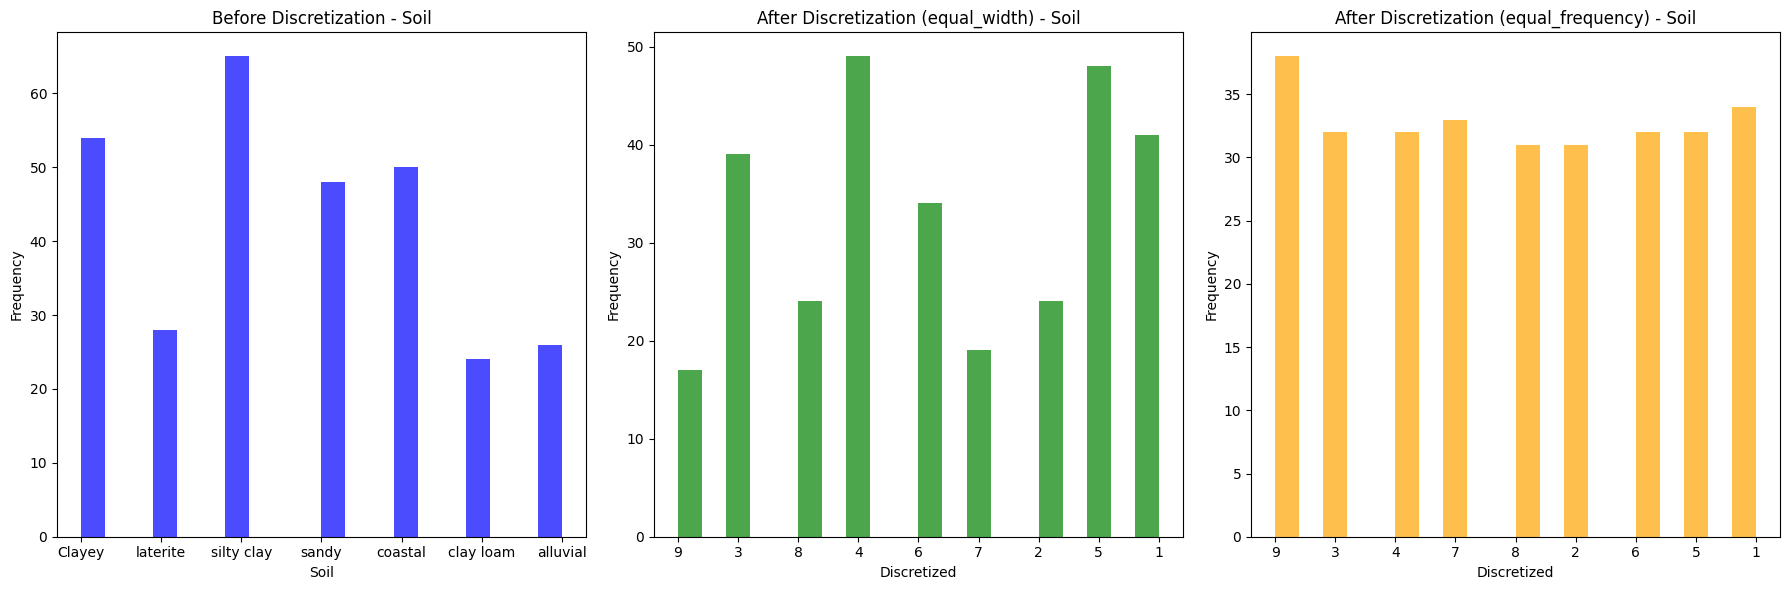

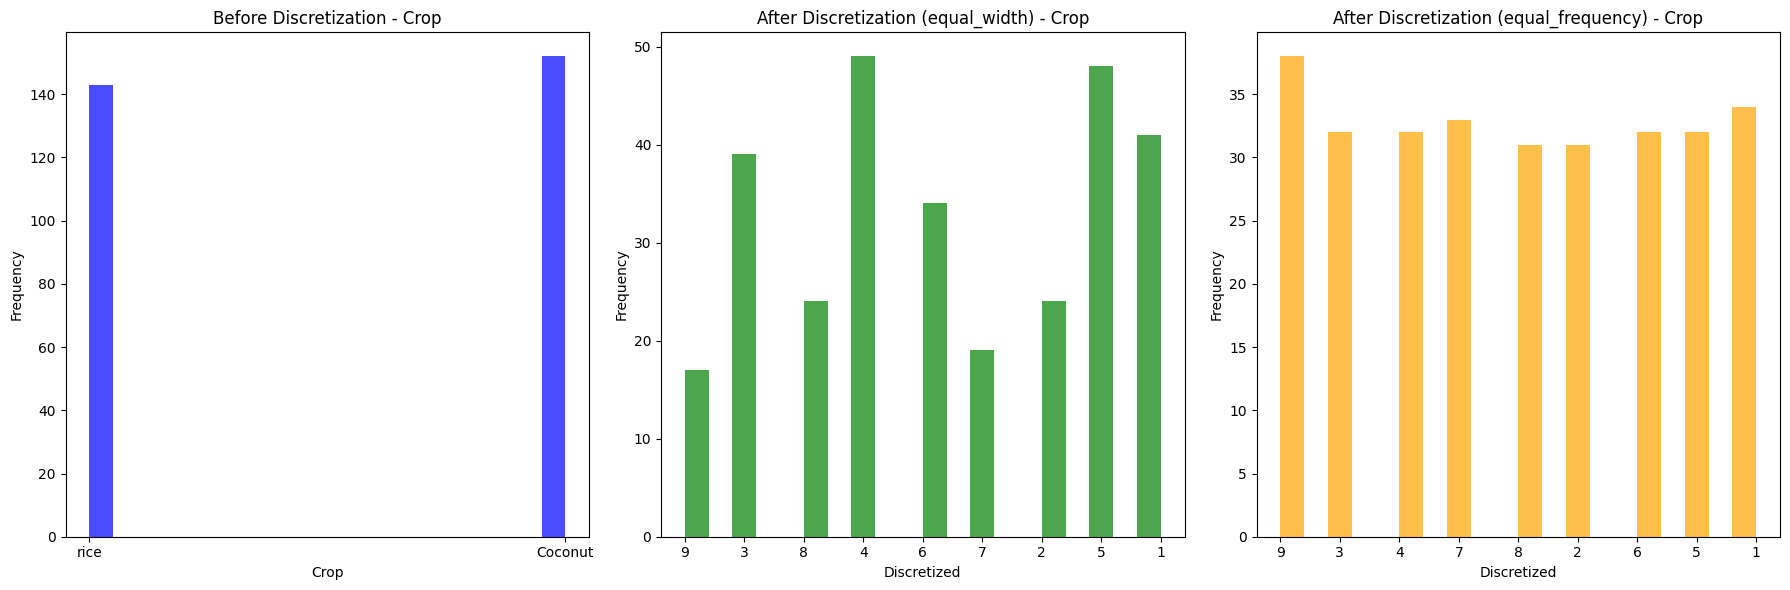

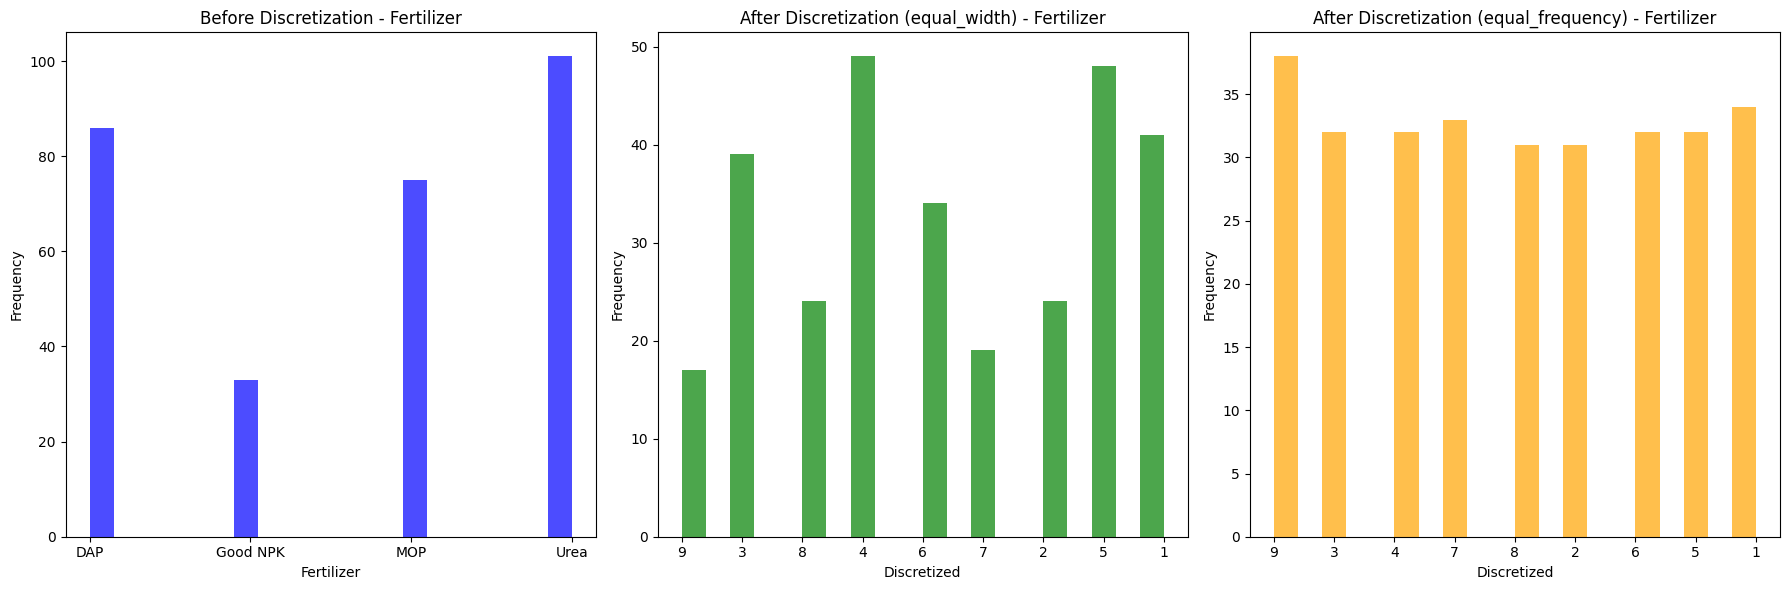

In [87]:
from utils import plot_before_after_discretization
attributes = data.columns

for attribute in attributes:
    plot_before_after_discretization(data, attribute, df_after, df_after2)
    

<h1>2.2. Extraction des motifs fréquents et règles d’association 

<h2>Motifs fréquents

In [88]:

df = equal_frequency_discretization(data, column_name, 2)
grouped = df_after2.groupby('Soil').agg({
    'Discretized': set,
    #'Humidity': set,
    #'Crop': set,
    #'Fertilizer': set
   
   
}).reset_index()
grouped.to_csv('./Data/Dataset3_bis.csv', index=False)

In [89]:
grouped

,Soil,Discretized
0,Clayey,"{3, 5, 7, 4, 6, 9, 8}"
1,alluvial,"{2, 3, 5, 7, 4, 6, 1}"
2,clay loam,"{3, 5, 7, 4, 6, 9, 8}"
3,coastal,"{2, 3, 5, 7, 4, 6, 1}"
4,laterite,"{2, 3, 5, 7, 4, 6, 1}"
5,sandy,"{2, 3, 5, 7, 4, 6, 1}"
6,silty clay,"{3, 5, 7, 4, 6, 9, 8}"


In [90]:
dataset = df_after2.groupby('Soil').agg({
    # 'Discretized': set,
    'Fertilizer': set
}).reset_index()
dataset.to_csv('./Data/Dataset-bis_bis.csv', index=False)
dataset


,Soil,Fertilizer
0,Clayey,"{Urea, Good NPK, MOP, DAP}"
1,alluvial,"{DAP, MOP, Urea}"
2,clay loam,"{Good NPK, DAP, MOP, Urea}"
3,coastal,"{DAP, Good NPK, MOP, Urea}"
4,laterite,"{Urea, Good NPK, MOP, DAP}"
5,sandy,"{DAP, Good NPK, MOP, Urea}"
6,silty clay,"{Urea, DAP, Good NPK, MOP}"


<h3>Apriori

In [91]:
#  Crée les candidats initiaux, qui sont les éléments individuels, à partir des données de transaction.
def create_initial_candidates(data):
    candidates = set()
    for transaction in data:
        for item in transaction:
            candidates.add(frozenset([item])) 
    return list(candidates)
# Calcule le support d'un itemset en parcourant les transactions et en comptant le nombre de fois où l'itemset apparaît dans chaque transaction.
def calculate_support(data, itemset):
    count = 0
    for transaction in data:
        if itemset.issubset(transaction):
            count += 1
    return count
# Élaguer les candidats qui ne répondent pas au support minimum.
def prune_candidates(candidates, prev_frequent_items, k):
    pruned_candidates = []
    for candidate in candidates:
        support = calculate_support(data, candidate)
        if support >= k:
            pruned_candidates.append(candidate)
    return pruned_candidates
# Génère de nouveaux candidats en combinant les candidats fréquents de la dernière étape.
def generate_candidates(prev_candidates, k):
    candidates = set()
    n = len(prev_candidates)
    for i in range(n):
        for j in range(i + 1, n):
            itemset1 = list(prev_candidates[i])
            itemset2 = list(prev_candidates[j])
            if itemset1[:-1] == itemset2[:-1]:
                new_candidate = frozenset(itemset1 + [itemset2[-1]])
                candidates.add(new_candidate)
    return list(candidates)
# L'algorithme Apriori.
def apriori(data, min_support):
    candidates = create_initial_candidates(data)
    k = 1
    frequent_itemsets = []
    while candidates:
        if frequent_itemsets:
            candidates = prune_candidates(candidates, frequent_itemsets[-1], min_support)
        frequent_itemsets.extend(candidates)
        k += 1
        candidates = generate_candidates(candidates, k)
    
    return frequent_itemsets
import itertools
def generate_association_rules(L, min_confidence, transactions):
    association_rules = []
    def calculate_support(itemset, transactions):
        count = 0
        for transaction in transactions:
            if itemset.issubset(transaction):
                count += 1
        return count
    for itemset in L:
        itemset_list = list(itemset)
        for i in range(1, len(itemset_list)):
            for combination in itertools.combinations(itemset_list, i):
                A = set(combination)
                B = itemset - A
                support_A = calculate_support(A, transactions)
                # print(support_A)
                support_AB = calculate_support(itemset, transactions)
                # print(support_AB)
                confidence = support_AB / support_A
                # print(confidence)
                if confidence >= min_confidence:
                    association_rules.append((A, B, confidence))
    return association_rules
def regles_d_association(data, min_support, min_confidence):
    frequent_itemsets = apriori(data, min_support)
    nombre_itemsets = len(frequent_itemsets)
    association_rules = generate_association_rules(frequent_itemsets, min_confidence, data)
    nomber_regles = len(association_rules)
    return association_rules, nombre_itemsets, nomber_regles


In [92]:
data = []
for index, row in dataset.iterrows():
    fertilizers = row['Fertilizer']
    data.append(set(fertilizers))
min_supports = [1,2,3, 4, 5, 6]
min_confidences = [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7,0.8, 0.9]
for min_support in min_supports:
    for min_confidence in min_confidences:
        association_rules, nombre_itemsets, nomber_regles = regles_d_association(data, min_support, min_confidence)
        with open('./Data/results_fert.csv', 'a') as f:
            f.write(f"{min_support},{min_confidence},{nombre_itemsets},{nomber_regles}\n")

In [93]:
data = []
for index, row in grouped.iterrows():
    desc = row['Discretized']
    data.append(set(desc))
min_supports = [1,2,3, 4, 5, 6]
min_confidences = [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7,0.8, 0.9]
for min_support in min_supports:
    for min_confidence in min_confidences:
        association_rules, nombre_itemsets, nomber_regles = regles_d_association(data, min_support, min_confidence)
        with open('./Data/results_desc.csv', 'a') as f:
            f.write(f"{min_support},{min_confidence},{nombre_itemsets},{nomber_regles}\n")

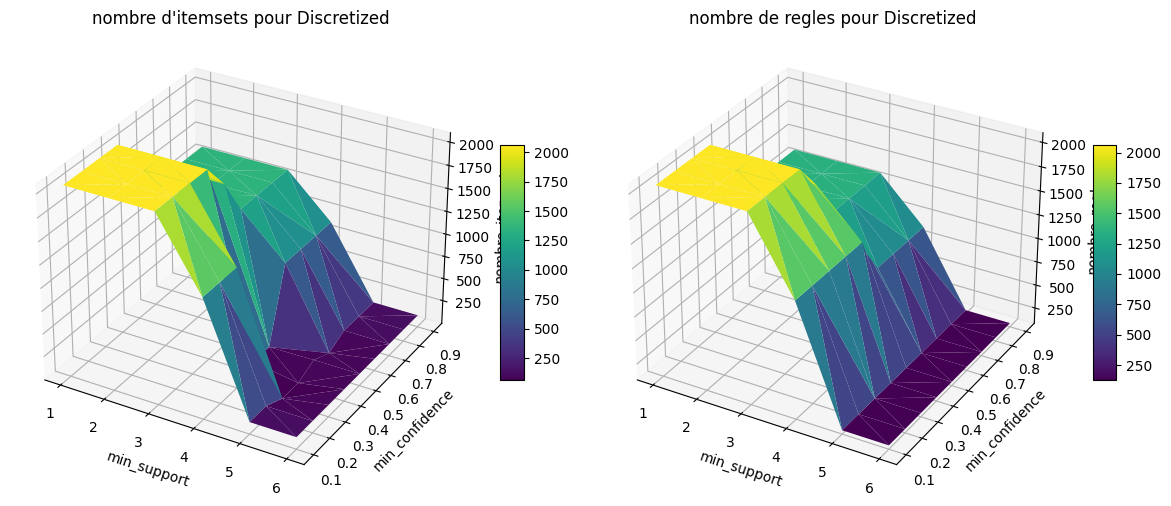

In [94]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
from matplotlib import cm

res_desc = pd.read_csv('./Data/results_desc.csv', names=['min_support', 'min_confidence', 'nombre_itemsets', 'nombre_regles'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': '3d'})


surf1 = ax1.plot_trisurf(res_desc['min_support'], res_desc['min_confidence'], res_desc['nombre_itemsets'], cmap=cm.viridis)
ax1.set_xlabel('min_support')
ax1.set_ylabel('min_confidence')
ax1.set_zlabel('nombre_itemsets')
ax1.set_title("nombre d'itemsets pour Discretized")
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

surf2 = ax2.plot_trisurf(res_desc['min_support'], res_desc['min_confidence'], res_desc['nombre_regles'], cmap=cm.viridis)
ax2.set_xlabel('min_support')
ax2.set_ylabel('min_confidence')
ax2.set_zlabel('nombre_regles')
ax2.set_title('nombre de regles pour Discretized')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()

plt.show()


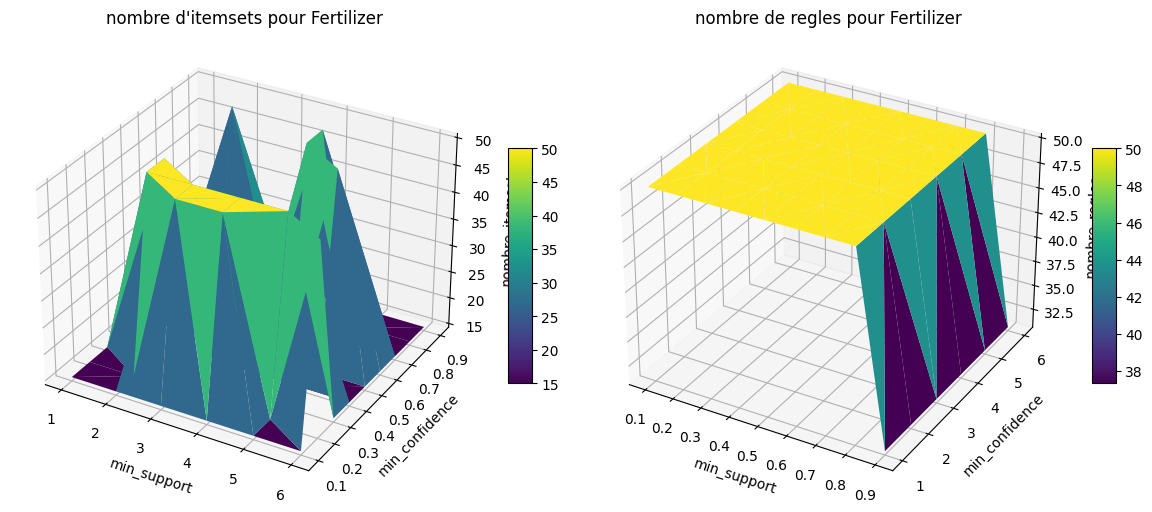

In [95]:
res_fert = pd.read_csv('./Data/results_fert.csv', names=['min_support', 'min_confidence', 'nombre_itemsets', 'nombre_regles'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': '3d'})
surf1 = ax1.plot_trisurf(res_fert['min_support'], res_fert['min_confidence'], res_fert['nombre_itemsets'], cmap=cm.viridis)
ax1.set_xlabel('min_support')
ax1.set_ylabel('min_confidence')
ax1.set_zlabel('nombre_itemsets')
ax1.set_title("nombre d'itemsets pour Fertilizer")
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

surf2 = ax2.plot_trisurf(res_fert['min_confidence'], res_fert['min_support'], res_fert['nombre_regles'], cmap=cm.viridis)
ax2.set_xlabel('min_support')
ax2.set_ylabel('min_confidence')
ax2.set_zlabel('nombre_regles')
ax2.set_title('nombre de regles pour Fertilizer')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()

plt.show()


In [96]:
data = []
for index, row in dataset.iterrows():
    fertilizers = row['Fertilizer']
    data.append(set(fertilizers))
min_support = 5
min_confidence = 0.9
association_rules, nombre_itemsets, nomber_regles = regles_d_association(data, min_support, min_confidence)
print(f"Nombre d'itemsets fréquents: {nombre_itemsets}")
print(f"Nombre de règles d'association: {nomber_regles}")
for rule in association_rules:
    A, B, confidence = rule
    print(f"{list(A)} => {list(B)} - Conf: {confidence}")

Nombre d'itemsets fréquents: 15
Nombre de règles d'association: 31
['DAP'] => ['Urea'] - Conf: 1.0
['Urea'] => ['DAP'] - Conf: 1.0
['Good NPK'] => ['DAP'] - Conf: 1.0
['Good NPK'] => ['Urea'] - Conf: 1.0
['MOP'] => ['Urea'] - Conf: 1.0
['Urea'] => ['MOP'] - Conf: 1.0
['DAP'] => ['MOP'] - Conf: 1.0
['MOP'] => ['DAP'] - Conf: 1.0
['Good NPK'] => ['MOP'] - Conf: 1.0
['Good NPK'] => ['Urea', 'MOP'] - Conf: 1.0
['Good NPK', 'MOP'] => ['Urea'] - Conf: 1.0
['Good NPK', 'Urea'] => ['MOP'] - Conf: 1.0
['Good NPK'] => ['DAP', 'MOP'] - Conf: 1.0
['Good NPK', 'MOP'] => ['DAP'] - Conf: 1.0
['Good NPK', 'DAP'] => ['MOP'] - Conf: 1.0
['Good NPK'] => ['DAP', 'Urea'] - Conf: 1.0
['Good NPK', 'Urea'] => ['DAP'] - Conf: 1.0
['Good NPK', 'DAP'] => ['Urea'] - Conf: 1.0
['Urea'] => ['DAP', 'MOP'] - Conf: 1.0
['MOP'] => ['DAP', 'Urea'] - Conf: 1.0
['DAP'] => ['MOP', 'Urea'] - Conf: 1.0
['MOP', 'Urea'] => ['DAP'] - Conf: 1.0
['DAP', 'Urea'] => ['MOP'] - Conf: 1.0
['DAP', 'MOP'] => ['Urea'] - Conf: 1.0
['Good 

In [97]:
data = []
for index, row in grouped.iterrows():
    desc = row['Discretized']
    data.append(set(desc))
min_support = 5
min_confidence = 0.9
association_rules, nombre_itemsets, nomber_regles = regles_d_association(data, min_support, min_confidence)
print(f"Nombre d'itemsets fréquents: {nombre_itemsets}")
print(f"Nombre de règles d'association: {nomber_regles}")
for rule in association_rules:
    A, B, confidence = rule
    print(f"{list(A)} => {list(B)} - Conf: {confidence}")

Nombre d'itemsets fréquents: 32
Nombre de règles d'association: 122
['3'] => ['6'] - Conf: 1.0
['6'] => ['3'] - Conf: 1.0
['3'] => ['4'] - Conf: 1.0
['4'] => ['3'] - Conf: 1.0
['4'] => ['5'] - Conf: 1.0
['5'] => ['4'] - Conf: 1.0
['5'] => ['6'] - Conf: 1.0
['6'] => ['5'] - Conf: 1.0
['6'] => ['7'] - Conf: 1.0
['7'] => ['6'] - Conf: 1.0
['4'] => ['6'] - Conf: 1.0
['6'] => ['4'] - Conf: 1.0
['5'] => ['7'] - Conf: 1.0
['7'] => ['5'] - Conf: 1.0
['3'] => ['7'] - Conf: 1.0
['7'] => ['3'] - Conf: 1.0
['3'] => ['5'] - Conf: 1.0
['5'] => ['3'] - Conf: 1.0
['4'] => ['7'] - Conf: 1.0
['7'] => ['4'] - Conf: 1.0
['4'] => ['5', '7'] - Conf: 1.0
['5'] => ['4', '7'] - Conf: 1.0
['7'] => ['4', '5'] - Conf: 1.0
['4', '5'] => ['7'] - Conf: 1.0
['4', '7'] => ['5'] - Conf: 1.0
['5', '7'] => ['4'] - Conf: 1.0
['4'] => ['6', '7'] - Conf: 1.0
['6'] => ['4', '7'] - Conf: 1.0
['7'] => ['4', '6'] - Conf: 1.0
['4', '6'] => ['7'] - Conf: 1.0
['4', '7'] => ['6'] - Conf: 1.0
['6', '7'] => ['4'] - Conf: 1.0
['5'] =>